In [1]:
# The purpose of this file is to use multinomial, RF, and logistic regression to predict the endotype of the 6 cohorts 
# we will calculate the accuracy of the prediction and the importance of the features
# we will also calculate the sensitivity and specificity of the prediction as well as PPV and NPV 
# created by Zhongyu Li, May 2024 
# updated to add LR model using standard units, June 2024
# Note: we will only use 6 cohort with HOMA2IR and HOMA2B data

In [2]:
# load libraries
import pandas as pd 
import numpy as np
import os as os

import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression



In [17]:
os. getlogin()

'root'

In [ ]:
#not working, need to figure out why as of 5.18.24 

os. getlogin()

if os.getlogin()=="JVARGH7":
    path_folder = 'C:/Cloud/Emory University/li, zhongyu - Diabetes Endotypes Project (JV and ZL)'
if os.getlogin()=='zhongyuli':
    path_folder = '/Users/zhongyuli/Library/CloudStorage/OneDrive-EmoryUniversity/Diabetes Endotypes Project (JV and ZL)'

# Rename the dataset into analytic sample
analytic_dataset = pd.read_csv(path_folder + '/working/processed/final_dataset.csv')


In [10]:
# first, we will load the data and conduct k means clustering to create the "TRUE labels"
# we will use the HOMA2IR and HOMA2B data to create the labels
# we will use the first 6 cohorts


path = '/Users/zhongyuli/Desktop/python/cluster analysis/dataset/final_dataset.csv'

analytic_dataset = pd.read_csv(path) 

#drop missing values
method3_df = analytic_dataset[analytic_dataset['method3'] == 1]

#select variables 
selected_variables = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir','tgl','ldlc','ratio_th','sbp','dbp','hdlc','study']

#drop missing values in the selected variables
method3_df = method3_df[selected_variables]
method3_df = method3_df.dropna()

#check the data
method3_df.head()



,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc,study
0,33.37665,6.9,70.0,102.7,2.217295,124,83.0,3.179487,119.2454,65.9166,39.0,jhs
1,27.76165,6.5,68.0,113.6,1.945525,101,81.0,1.980392,119.2454,65.0865,51.0,jhs
2,30.73822,7.9,51.0,40.6,2.192982,117,131.0,3.342857,162.3397,99.1206,35.0,jhs
3,43.56290,6.9,65.0,99.9,2.469136,78,97.0,1.322034,130.2482,70.0671,59.0,jhs
4,29.33333,6.5,77.0,104.9,2.577320,158,112.0,2.724138,121.0792,64.2564,58.0,jhs


In [19]:
# Redefine a new dataset with method 3 and method 4 both equal to 1
#method_tp = analytic_dataset[(analytic_dataset['method3'] == 1) & (analytic_dataset['method4'] == 1)]

# Get the shape of the new dataset
#method_tp_shape = method_tp.shape
#print(method_tp_shape)

# check if there are any missing values in the new dataset in the selected variables
#method_tp = method_tp[selected_variables]
#method_tp.isnull().sum()

(3782, 24)


In [11]:
#take out the "study" variable
study = method3_df['study']
method3_df = method3_df.drop(columns = ['study']) 

method3_df.shape

(3771, 11)

In [21]:
# check if there are any missing values
method3_df.isnull().sum()
# check variable types
method3_df.dtypes



bmi          float64
hba1c        float64
dmagediag    float64
homa2b       float64
homa2ir      float64
tgl            int64
ldlc         float64
ratio_th     float64
sbp          float64
dbp          float64
hdlc         float64
dtype: object

In [22]:
#run kmeans clustering to create the TRUE labels
#standardize the data
scaler = StandardScaler()
method3_df_scaled = scaler.fit_transform(method3_df)

method3_df_scaled = pd.DataFrame(method3_df_scaled, columns=method3_df.columns)



In [23]:
method3_df_scaled.head()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
0,-0.032257,0.300357,0.645757,-0.220785,-0.458673,-0.242366,-0.774925,-0.090932,-0.326612,-0.636184,-0.668157
1,-0.832829,-0.048265,0.489212,-0.091397,-0.560173,-0.512939,-0.830633,-0.511314,-0.326612,-0.692720,0.252415
2,-0.408438,1.171911,-0.841426,-0.957942,-0.467753,-0.324714,0.562068,-0.033657,1.987405,1.625245,-0.975014
3,1.420073,0.300357,0.254393,-0.254023,-0.364617,-0.783512,-0.384969,-0.742123,0.264201,-0.353505,0.866129
4,-0.608743,-0.048265,1.193667,-0.194670,-0.324213,0.157612,0.032841,-0.250570,-0.228143,-0.749256,0.789414


In [24]:
# run kmeans and get cluster labels from the five variable method (method 3)
kmeans = KMeans(
    init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57
)

# select five variables to cluster
var_m3 = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir']
cluster_m3 = method3_df_scaled[var_m3]

kmeans = KMeans(init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57)
kmeans.fit(cluster_m3)

KMeans(init='random', n_clusters=4, n_init=10, random_state=57)

In [25]:
# summarize the cluster labels 
method3_df_cluster = method3_df.copy()
method3_df_cluster['cluster'] = kmeans.labels_
method3_df_cluster['cluster'].value_counts()


cluster
0    1766
1    1481
3     290
2     234
Name: count, dtype: int64

In [26]:
#summarize variables by cluster
method3_df_cluster.groupby('cluster').mean()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
cluster,,,,,,,,,,,
0,29.624151,6.269762,70.743322,86.821631,2.107629,133.261608,106.051076,2.960120,127.687002,70.621010,50.251076
1,38.086894,6.384085,51.314338,133.598042,3.866042,155.496286,117.407562,3.903651,122.223853,80.640832,44.889804
2,34.958178,9.900000,55.524927,52.536325,3.077110,149.948718,116.474359,3.587225,126.418088,80.898582,47.239316
3,33.839130,6.470690,65.299499,323.935517,9.741132,153.713793,101.668966,3.860884,125.934720,71.448641,47.013793


In [10]:
# remane the cluster labels
method3_df_cluster['cluster'] = method3_df_cluster['cluster'].replace({0: 'MARD', 1: 'MOD', 2: 'SIDD', 3: 'SIRD'})
method3_df_cluster['cluster'].value_counts()


cluster
MARD    1766
MOD     1481
SIRD     290
SIDD     234
Name: count, dtype: int64

In [11]:
#summarize variables by cluster
method3_df_cluster.groupby('cluster').mean()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
cluster,,,,,,,,,,,
MARD,29.624151,6.269762,70.743322,86.821631,2.107629,133.261608,106.051076,2.960120,127.687002,70.621010,50.251076
MOD,38.086894,6.384085,51.314338,133.598042,3.866042,155.496286,117.407562,3.903651,122.223853,80.640832,44.889804
SIDD,34.958178,9.900000,55.524927,52.536325,3.077110,149.948718,116.474359,3.587225,126.418088,80.898582,47.239316
SIRD,33.839130,6.470690,65.299499,323.935517,9.741132,153.713793,101.668966,3.860884,125.934720,71.448641,47.013793


### NOW we will run multinomial regression to predict each group. 

##### one split, no CV [not picked]

In [68]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method3_df_cluster[var_m4]
y = method3_df_cluster['cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57, stratify=y)

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=57)
model.fit(X_train_scaled, y_train)

# Predict the class labels
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Generate the classification report for the test set
report = classification_report(y_test, y_test_pred, output_dict=True)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate Sensitivity, Specificity, PPV, NPV for each class
def calculate_metrics(conf_matrix, labels):
    metrics = {}
    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
        
        metrics[label] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': PPV,
            'NPV': NPV
        }
    
    return metrics

# Define the labels based on your domain knowledge
labels = ['MARD', 'MOD', 'SIDD', 'SIRD']

# Calculate and print metrics
metrics = calculate_metrics(conf_matrix, labels)
print("\nMetrics for each class:")
for cls, cls_metrics in metrics.items():
    print(f'{cls}:')
    for metric, value in cls_metrics.items():
        print(f'  {metric}: {value:.4f}')

# Summary of performance metrics
summary_report = {
    'Model': 'Multinomial Logistic Regression',
    'Accuracy': report['accuracy'],
    'Sensitivity (Per Class)': {cls: metrics[cls]['Sensitivity'] for cls in metrics},
    'Specificity (Per Class)': {cls: metrics[cls]['Specificity'] for cls in metrics},
    'PPV (Per Class)': {cls: metrics[cls]['PPV'] for cls in metrics},
    'NPV (Per Class)': {cls: metrics[cls]['NPV'] for cls in metrics}
}

print("\nSummary Report")
for key, value in summary_report.items():
    if isinstance(value, dict):
        print(f'{key}:')
        for sub_key, sub_value in value.items():
            print(f'  {sub_key}: {sub_value:.4f}')
    else:
        print(f'{key}: {value}')


Classification Report:
              precision    recall  f1-score   support

        MARD       0.87      0.94      0.90       530
         MOD       0.86      0.94      0.90       445
        SIDD       0.91      0.91      0.91        70
        SIRD       0.00      0.00      0.00        87

    accuracy                           0.87      1132
   macro avg       0.66      0.70      0.68      1132
weighted avg       0.80      0.87      0.83      1132


Metrics for each class:
MARD:
  Sensitivity: 0.9434
  Specificity: 0.8738
  PPV: 0.8681
  NPV: 0.9460
MOD:
  Sensitivity: 0.9371
  Specificity: 0.9025
  PPV: 0.8616
  NPV: 0.9568
SIDD:
  Sensitivity: 0.9143
  Specificity: 0.9944
  PPV: 0.9143
  NPV: 0.9944
SIRD:
  Sensitivity: 0.0000
  Specificity: 0.9981
  PPV: 0.0000
  NPV: 0.9230

Summary Report
Model: Multinomial Logistic Regression
Accuracy: 0.8666077738515902
Sensitivity (Per Class):
  MARD: 0.9434
  MOD: 0.9371
  SIDD: 0.9143
  SIRD: 0.0000
Specificity (Per Class):
  MARD: 0.87

##### Five fold CV, one split [this is the preferred workflow]

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method3_df_cluster[var_m4]
y = method3_df_cluster['cluster']

# Split the data into training and testing sets (30% test dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57, stratify=y)

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the multinomial logistic regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=57)

# Perform 5-fold cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

# Cross-validation for Multinomial Logistic Regression
y_train_pred_proba_logistic = cross_val_predict(logistic_model, X_train_scaled, y_train, cv=cv, method='predict_proba')
logistic_model.fit(X_train_scaled, y_train)
y_test_pred_logistic = logistic_model.predict(X_test_scaled)
y_test_pred_proba_logistic = logistic_model.predict_proba(X_test_scaled)

# Generate the classification report for the test set
print("\nClassification Report for Multinomial Logistic Regression:")
print(classification_report(y_test, y_test_pred_logistic))

# Calculate confusion matrix for the test set
conf_matrix_logistic = confusion_matrix(y_test, y_test_pred_logistic)

# Calculate Sensitivity, Specificity, PPV, NPV for each class
def calculate_metrics(conf_matrix, labels):
    metrics = {}
    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
        
        metrics[label] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': PPV,
            'NPV': NPV
        }
    
    return metrics

# Define the labels based on your domain knowledge
labels = ['MARD', 'MOD', 'SIDD', 'SIRD']

# Calculate and print metrics for Multinomial Logistic Regression
metrics_logistic = calculate_metrics(conf_matrix_logistic, labels)
print("\nMetrics for each class (Multinomial Logistic Regression):")
for cls, cls_metrics in metrics_logistic.items():
    print(f'{cls}:')
    for metric, value in cls_metrics.items():
        print(f'  {metric}: {value:.4f}')

# Summary of performance metrics for Multinomial Logistic Regression
summary_report_logistic = {
    'Model': 'Multinomial Logistic Regression',
    'Accuracy': classification_report(y_test, y_test_pred_logistic, output_dict=True)['accuracy'],
    'Sensitivity (Per Class)': {cls: metrics_logistic[cls]['Sensitivity'] for cls in metrics_logistic},
    'Specificity (Per Class)': {cls: metrics_logistic[cls]['Specificity'] for cls in metrics_logistic},
    'PPV (Per Class)': {cls: metrics_logistic[cls]['PPV'] for cls in metrics_logistic},
    'NPV (Per Class)': {cls: metrics_logistic[cls]['NPV'] for cls in metrics_logistic}
}

print("\nSummary Report (Multinomial Logistic Regression)")
for key, value in summary_report_logistic.items():
    if isinstance(value, dict):
        print(f'{key}:')
        for sub_key, sub_value in value.items():
            print(f'  {sub_key}: {sub_value:.4f}')
    else:
        print(f'{key}: {value}')



Classification Report for Multinomial Logistic Regression:
              precision    recall  f1-score   support

        MARD       0.87      0.94      0.90       530
         MOD       0.86      0.94      0.90       445
        SIDD       0.91      0.91      0.91        70
        SIRD       0.00      0.00      0.00        87

    accuracy                           0.87      1132
   macro avg       0.66      0.70      0.68      1132
weighted avg       0.80      0.87      0.83      1132


Metrics for each class (Multinomial Logistic Regression):
MARD:
  Sensitivity: 0.9434
  Specificity: 0.8738
  PPV: 0.8681
  NPV: 0.9460
MOD:
  Sensitivity: 0.9371
  Specificity: 0.9025
  PPV: 0.8616
  NPV: 0.9568
SIDD:
  Sensitivity: 0.9143
  Specificity: 0.9944
  PPV: 0.9143
  NPV: 0.9944
SIRD:
  Sensitivity: 0.0000
  Specificity: 0.9981
  PPV: 0.0000
  NPV: 0.9230

Summary Report (Multinomial Logistic Regression)
Model: Multinomial Logistic Regression
Accuracy: 0.8666077738515902
Sensitivity (Per 

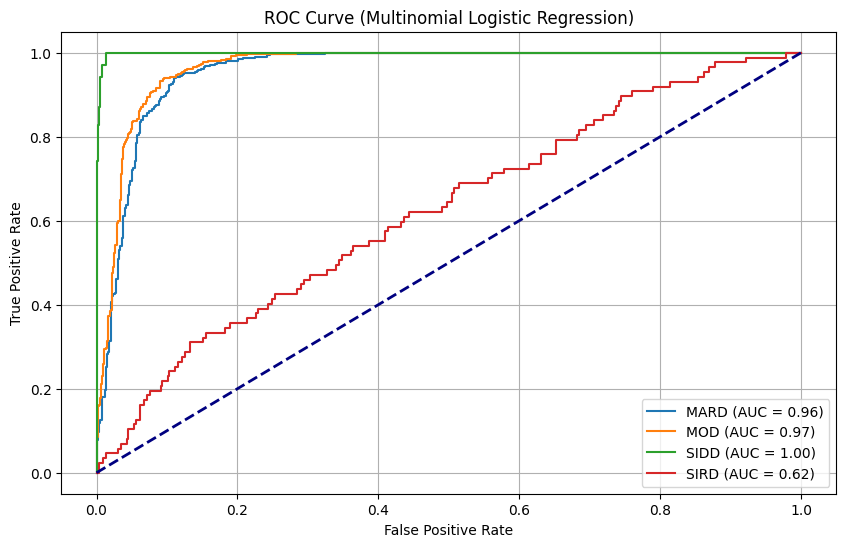

In [70]:
# Plot ROC curve for Multinomial Logistic Regression
plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=labels)[:, i], y_test_pred_proba_logistic[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend()
plt.grid()
plt.show()



#### Five fold CVs, no initial split

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming method3_df_cluster is your DataFrame
# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method3_df_cluster[var_m4]
y = method3_df_cluster['cluster']

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the multinomial logistic regression model
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=57)

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

# Cross-validation for Multinomial Logistic Regression
y_pred_proba_logistic = cross_val_predict(logistic_model, X_scaled, y, cv=cv, method='predict_proba')
y_pred_logistic = cross_val_predict(logistic_model, X_scaled, y, cv=cv)

# Generate the classification report
print("\nClassification Report for Multinomial Logistic Regression:")
print(classification_report(y, y_pred_logistic))

# Calculate confusion matrix
conf_matrix_logistic = confusion_matrix(y, y_pred_logistic)
print("Confusion Matrix:")
print(conf_matrix_logistic)

# Define the labels based on your domain knowledge
labels = ['MARD', 'MOD', 'SIDD', 'SIRD']

# Calculate Sensitivity, Specificity, PPV, NPV for each class
def calculate_metrics(conf_matrix, labels):
    metrics = {}
    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
        
        metrics[label] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': PPV,
            'NPV': NPV
        }
    
    return metrics

# Calculate and print metrics for Multinomial Logistic Regression
metrics_logistic = calculate_metrics(conf_matrix_logistic, labels)
print("\nMetrics for each class (Multinomial Logistic Regression):")
for cls, cls_metrics in metrics_logistic.items():
    print(f'{cls}:')
    for metric, value in cls_metrics.items():
        print(f'  {metric}: {value:.4f}')

# Summary of performance metrics for Multinomial Logistic Regression
summary_report_logistic = {
    'Model': 'Multinomial Logistic Regression',
    'Accuracy': classification_report(y, y_pred_logistic, output_dict=True)['accuracy'],
    'Sensitivity (Per Class)': {cls: metrics_logistic[cls]['Sensitivity'] for cls in metrics_logistic},
    'Specificity (Per Class)': {cls: metrics_logistic[cls]['Specificity'] for cls in metrics_logistic},
    'PPV (Per Class)': {cls: metrics_logistic[cls]['PPV'] for cls in metrics_logistic},
    'NPV (Per Class)': {cls: metrics_logistic[cls]['NPV'] for cls in metrics_logistic}
}

print("\nSummary Report (Multinomial Logistic Regression)")
for key, value in summary_report_logistic.items():
    if isinstance(value, dict):
        print(f'{key}:')
        for sub_key, sub_value in value.items():
            print(f'  {sub_key}: {sub_value:.4f}')
    else:
        print(f'{key}: {value}')






Classification Report for Multinomial Logistic Regression:
              precision    recall  f1-score   support

        MARD       0.86      0.94      0.90      1766
         MOD       0.87      0.93      0.90      1481
        SIDD       0.93      0.91      0.92       234
        SIRD       0.06      0.00      0.01       290

    accuracy                           0.86      3771
   macro avg       0.68      0.70      0.68      3771
weighted avg       0.80      0.86      0.83      3771

Confusion Matrix:
[[1664   90    2   10]
 [  98 1370    6    7]
 [   5   15  214    0]
 [ 177  105    7    1]]

Metrics for each class (Multinomial Logistic Regression):
MARD:
  Sensitivity: 0.9422
  Specificity: 0.8603
  PPV: 0.8560
  NPV: 0.9442
MOD:
  Sensitivity: 0.9251
  Specificity: 0.9083
  PPV: 0.8671
  NPV: 0.9493
SIDD:
  Sensitivity: 0.9145
  Specificity: 0.9958
  PPV: 0.9345
  NPV: 0.9944
SIRD:
  Sensitivity: 0.0034
  Specificity: 0.9951
  PPV: 0.0556
  NPV: 0.9230

Summary Report (Multino

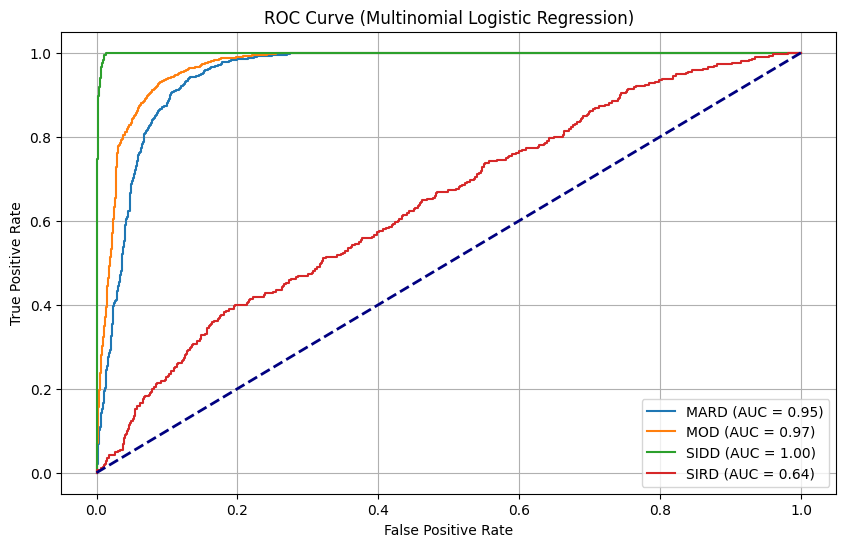

In [72]:
# Plot ROC curve for Multinomial Logistic Regression
plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(label_binarize(y, classes=labels)[:, i], y_pred_proba_logistic[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multinomial Logistic Regression)')
plt.legend()
plt.grid()
plt.show()



#### Now use Random Forest 

##### 5 fold CV, one split [this is the preferred workflow]

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming method3_df_cluster is your DataFrame
# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method3_df_cluster[var_m4]
y = method3_df_cluster['cluster']

# Split the data into training and testing sets (30% test dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57, stratify=y)

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=57, class_weight='balanced')

# Perform 5-fold cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

# Cross-validation for Random Forest
y_train_pred_proba_rf = cross_val_predict(rf_model, X_train_scaled, y_train, cv=cv, method='predict_proba')
rf_model.fit(X_train_scaled, y_train)
y_test_pred_rf = rf_model.predict(X_test_scaled)
y_test_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

# Generate the classification report for the test set
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_test_pred_rf,zero_division=0))

# Calculate confusion matrix for the test set
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
print(conf_matrix_rf)
# Calculate Sensitivity, Specificity, PPV, NPV for each class
def calculate_metrics(conf_matrix, labels):
    metrics = {}
    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
        
        metrics[label] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': PPV,
            'NPV': NPV
        }
    
    return metrics

# Define the labels based on your domain knowledge
labels = ['MARD', 'MOD', 'SIDD', 'SIRD']

# Calculate and print metrics for Random Forest
metrics_rf = calculate_metrics(conf_matrix_rf, labels)
print("\nMetrics for each class (Random Forest):")
for cls, cls_metrics in metrics_rf.items():
    print(f'{cls}:')
    for metric, value in cls_metrics.items():
        print(f'  {metric}: {value:.4f}')

# Summary of performance metrics for Random Forest
summary_report_rf = {
    'Model': 'Random Forest Classifier',
    'Accuracy': classification_report(y_test, y_test_pred_rf, output_dict=True)['accuracy'],
    'Sensitivity (Per Class)': {cls: metrics_rf[cls]['Sensitivity'] for cls in metrics_rf},
    'Specificity (Per Class)': {cls: metrics_rf[cls]['Specificity'] for cls in metrics_rf},
    'PPV (Per Class)': {cls: metrics_rf[cls]['PPV'] for cls in metrics_rf},
    'NPV (Per Class)': {cls: metrics_rf[cls]['NPV'] for cls in metrics_rf}
}

print("\nSummary Report (Random Forest)")
for key, value in summary_report_rf.items():
    if isinstance(value, dict):
        print(f'{key}:')
        for sub_key, sub_value in value.items():
            print(f'  {sub_key}: {sub_value:.4f}')
    else:
        print(f'{key}: {value}')


Classification Report for Random Forest:
              precision    recall  f1-score   support

        MARD       0.86      0.94      0.90       530
         MOD       0.86      0.92      0.89       445
        SIDD       0.86      0.93      0.89        70
        SIRD       0.00      0.00      0.00        87

    accuracy                           0.86      1132
   macro avg       0.64      0.70      0.67      1132
weighted avg       0.79      0.86      0.83      1132

[[497  29   4   0]
 [ 31 411   3   0]
 [  2   3  65   0]
 [ 46  37   4   0]]

Metrics for each class (Random Forest):
MARD:
  Sensitivity: 0.9377
  Specificity: 0.8688
  PPV: 0.8628
  NPV: 0.9406
MOD:
  Sensitivity: 0.9236
  Specificity: 0.8996
  PPV: 0.8562
  NPV: 0.9479
SIDD:
  Sensitivity: 0.9286
  Specificity: 0.9896
  PPV: 0.8553
  NPV: 0.9953
SIRD:
  Sensitivity: 0.0000
  Specificity: 1.0000
  PPV: 0.0000
  NPV: 0.9231

Summary Report (Random Forest)
Model: Random Forest Classifier
Accuracy: 0.8595406360424028
S

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

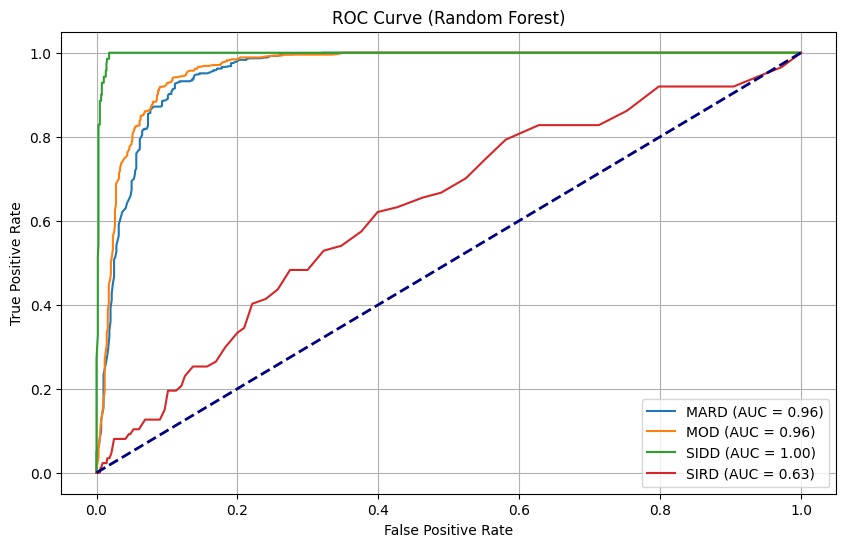

In [75]:
# Plot ROC curve for Random Forest
plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=labels)[:, i], y_test_pred_proba_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend()
plt.grid()
plt.show()


#### Five folds CV, no split

In [80]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming method3_df_cluster is your DataFrame
# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method3_df_cluster[var_m4]
y = method3_df_cluster['cluster']

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=200, random_state=57, class_weight='balanced')

# Perform stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

# Cross-validation for Random Forest
y_pred_proba_rf = cross_val_predict(model, X_scaled, y, cv=kf, method='predict_proba')
y_pred_rf = cross_val_predict(model, X_scaled, y, cv=kf)

# Generate the classification report
print("\nClassification Report for Random Forest:")
print(classification_report(y, y_pred_rf, zero_division=0))

# Calculate confusion matrix
conf_matrix_rf = confusion_matrix(y, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Define the labels based on your domain knowledge
labels = ['MARD', 'MOD', 'SIDD', 'SIRD']

# Calculate Sensitivity, Specificity, PPV, NPV for each class
def calculate_metrics(conf_matrix, labels):
    metrics = {}
    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
        
        metrics[label] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': PPV,
            'NPV': NPV
        }
    
    return metrics

# Calculate and print metrics for Random Forest
metrics_rf = calculate_metrics(conf_matrix_rf, labels)
print("\nMetrics for each class (Random Forest):")
for cls, cls_metrics in metrics_rf.items():
    print(f'{cls}:')
    for metric, value in cls_metrics.items():
        print(f'  {metric}: {value:.4f}')

# Summary of performance metrics for Random Forest
summary_report_rf = {
    'Model': 'Random Forest',
    'Accuracy': classification_report(y, y_pred_rf, output_dict=True)['accuracy'],
    'Sensitivity (Per Class)': {cls: metrics_rf[cls]['Sensitivity'] for cls in metrics_rf},
    'Specificity (Per Class)': {cls: metrics_rf[cls]['Specificity'] for cls in metrics_rf},
    'PPV (Per Class)': {cls: metrics_rf[cls]['PPV'] for cls in metrics_rf},
    'NPV (Per Class)': {cls: metrics_rf[cls]['NPV'] for cls in metrics_rf}
}

print("\nSummary Report (Random Forest)")
for key, value in summary_report_rf.items():
    if isinstance(value, dict):
        print(f'{key}:')
        for sub_key, sub_value in value.items():
            print(f'  {sub_key}: {sub_value:.4f}')
    else:
        print(f'{key}: {value}')



Classification Report for Random Forest:
              precision    recall  f1-score   support

        MARD       0.86      0.94      0.90      1766
         MOD       0.87      0.92      0.89      1481
        SIDD       0.86      0.94      0.90       234
        SIRD       0.00      0.00      0.00       290

    accuracy                           0.86      3771
   macro avg       0.65      0.70      0.67      3771
weighted avg       0.79      0.86      0.83      3771

Confusion Matrix:
[[1656   95   13    2]
 [  99 1367   14    1]
 [   4   10  220    0]
 [ 174  108    8    0]]

Metrics for each class (Random Forest):
MARD:
  Sensitivity: 0.9377
  Specificity: 0.8618
  PPV: 0.8567
  NPV: 0.9402
MOD:
  Sensitivity: 0.9230
  Specificity: 0.9070
  PPV: 0.8652
  NPV: 0.9480
SIDD:
  Sensitivity: 0.9402
  Specificity: 0.9901
  PPV: 0.8627
  NPV: 0.9960
SIRD:
  Sensitivity: 0.0000
  Specificity: 0.9991
  PPV: 0.0000
  NPV: 0.9230

Summary Report (Random Forest)
Model: Random Forest
Accurac

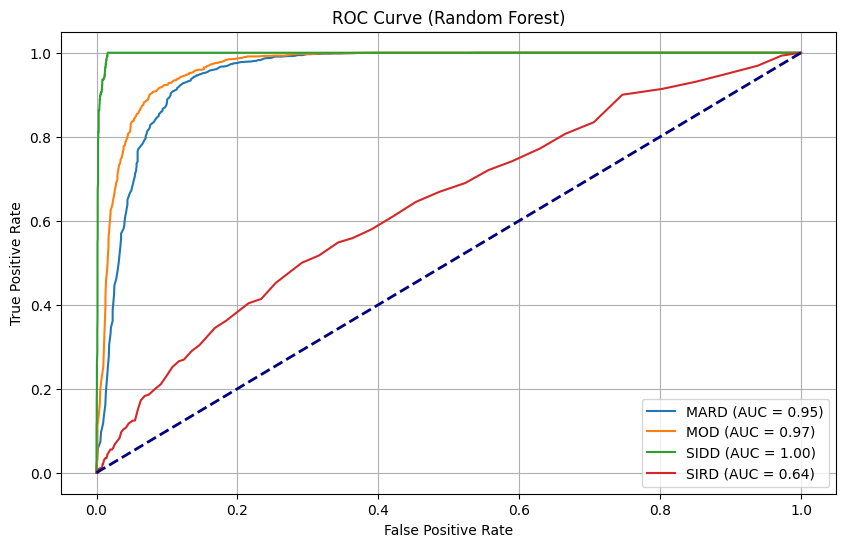

In [81]:
# Plot ROC curve for Random Forest
plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(label_binarize(y, classes=labels)[:, i], y_pred_proba_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend()
plt.grid()
plt.show()


#### Now use SIDD and non SIDD model

##### five fold CV, one split [this is the preferred workflow]

In [12]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Combine three groups (MARD, MOD, and SIRD) into a new group named "NON-SIDD"
method_lr = method3_df_cluster.copy()
method_lr['cluster'] = method_lr['cluster'].replace({'MARD': 'NON-SIDD', 'MOD': 'NON-SIDD', 'SIRD': 'NON-SIDD'})

# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method_lr[var_m4]
y = method_lr['cluster'].map({'NON-SIDD': 0, 'SIDD': 1})

# Split the data into training and testing sets (30% test dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57, stratify=y)

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=57)

# Evaluate the model using 5-fold cross-validation with predicted probabilities
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)
y_train_pred_proba_cv = cross_val_predict(model, X_train_scaled, y_train, cv=kf, method='predict_proba')

# Fit the model using the entire training dataset
model.fit(X_train_scaled, y_train)

# Obtain the coefficients
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Create a DataFrame to display the coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

print("Model Coefficients:")
print(coef_df)
print(f"Intercept: {intercept}")

# Predict the class labels on the test set
y_test_pred = model.predict(X_test_scaled)
y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Generate the classification report for the test set with class labels
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_test_pred, target_names=['NON-SIDD', 'SIDD'], zero_division=0))

# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Sensitivity, Specificity, PPV, NPV for each class
def calculate_metrics(conf_matrix, labels):
    metrics = {}
    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
        
        metrics[label] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': PPV,
            'NPV': NPV
        }
    
    return metrics

# Define the labels based on your domain knowledge
labels = ['NON-SIDD', 'SIDD']

# Calculate and print metrics for Logistic Regression
metrics_lr = calculate_metrics(conf_matrix, labels)
print("\nMetrics for each class (Logistic Regression):")
for cls, cls_metrics in metrics_lr.items():
    print(f'{cls}:')
    for metric, value in cls_metrics.items():
        print(f'  {metric}: {value:.4f}')

# Summary of performance metrics for Logistic Regression
summary_report_lr = {
    'Model': 'Logistic Regression',
    'Accuracy': classification_report(y_test, y_test_pred, output_dict=True)['accuracy'],
    'Sensitivity (Per Class)': {cls: metrics_lr[cls]['Sensitivity'] for cls in metrics_lr},
    'Specificity (Per Class)': {cls: metrics_lr[cls]['Specificity'] for cls in metrics_lr},
    'PPV (Per Class)': {cls: metrics_lr[cls]['PPV'] for cls in metrics_lr},
    'NPV (Per Class)': {cls: metrics_lr[cls]['NPV'] for cls in metrics_lr}
}

print("\nSummary Report (Logistic Regression)")
for key, value in summary_report_lr.items():
    if isinstance(value, dict):
        print(f'{key}:')
        for sub_key, sub_value in value.items():
            print(f'  {sub_key}: {sub_value:.4f}')
    else:
        print(f'{key}: {value}')


Model Coefficients:
     Feature  Coefficient
0        bmi    -0.295941
1      hba1c     4.564587
2  dmagediag    -0.647353
3        tgl     0.172790
4       ldlc    -0.137162
5   ratio_th    -0.260542
6        sbp     0.044765
7        dbp     0.087476
8       hdlc     0.169370
Intercept: -7.259301389948058

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    NON-SIDD       0.99      0.99      0.99      1062
        SIDD       0.91      0.86      0.88        70

    accuracy                           0.99      1132
   macro avg       0.95      0.93      0.94      1132
weighted avg       0.99      0.99      0.99      1132

Confusion Matrix:
[[1056    6]
 [  10   60]]

Metrics for each class (Logistic Regression):
NON-SIDD:
  Sensitivity: 0.9944
  Specificity: 0.8571
  PPV: 0.9906
  NPV: 0.9091
SIDD:
  Sensitivity: 0.8571
  Specificity: 0.9944
  PPV: 0.9091
  NPV: 0.9906

Summary Report (Logistic Regression)
Model: Logistic Regressio

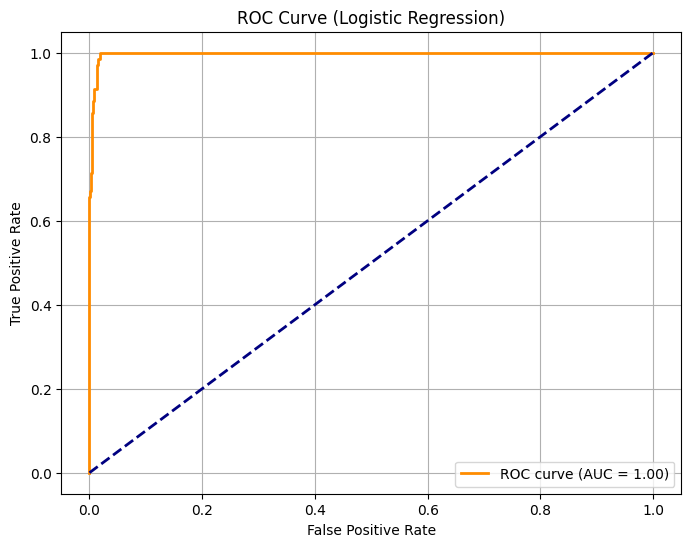

In [13]:
#create the ROC-AUC curve
# Plot ROC curve for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc='lower right')
plt.grid()
plt.show()



In [18]:
# output estimated coefficients
path_folder = '/Users/zhongyuli/Library/CloudStorage/OneDrive-EmoryUniversity/Diabetes Endotypes Project (JV and ZL)'

coef_df.to_csv(path_folder + '/working/processed/estimated_coefficients.csv', index=False)


In [20]:
# create the covariance matrix
cov_matrix = np.linalg.inv(np.dot(X_train_scaled.T, X_train_scaled))
cov_matrix = pd.DataFrame(cov_matrix, columns=X.columns, index=X.columns)
# check the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)
cov_matrix.to_csv(path_folder + '/working/processed/covariance_matrix.csv')

Covariance Matrix:
                bmi     hba1c  dmagediag       tgl      ldlc  ratio_th  \
bmi        0.000455 -0.000021   0.000173 -0.000026  0.000017  0.000045   
hba1c     -0.000021  0.000390   0.000023 -0.000016 -0.000028  0.000027   
dmagediag  0.000173  0.000023   0.000605 -0.000110  0.000107  0.000161   
tgl       -0.000026 -0.000016  -0.000110  0.004029 -0.000219 -0.004168   
ldlc       0.000017 -0.000028   0.000107 -0.000219  0.000428  0.000255   
ratio_th   0.000045  0.000027   0.000161 -0.004168  0.000255  0.004830   
sbp       -0.000044 -0.000016  -0.000148  0.000030 -0.000040 -0.000045   
dbp       -0.000014 -0.000025   0.000198 -0.000037 -0.000029  0.000024   
hdlc       0.000052  0.000012  -0.000030 -0.000716 -0.000003  0.000995   

                sbp       dbp      hdlc  
bmi       -0.000044 -0.000014  0.000052  
hba1c     -0.000016 -0.000025  0.000012  
dmagediag -0.000148  0.000198 -0.000030  
tgl        0.000030 -0.000037 -0.000716  
ldlc      -0.000040 -0.000029 

#### The above model may be incorrect in generating covariance matrix. Will try statsmodels next. 

In [24]:
# use statsmodels to estimate the coefficients
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Combine three groups (MARD, MOD, and SIRD) into a new group named "NON-SIDD"
method_lr = method3_df_cluster.copy()
method_lr['cluster'] = method_lr['cluster'].replace({'MARD': 'NON-SIDD', 'MOD': 'NON-SIDD', 'SIRD': 'NON-SIDD'})

# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method_lr[var_m4]
y = method_lr['cluster'].map({'NON-SIDD': 0, 'SIDD': 1})

# Split the data into training and testing sets (30% test dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57, stratify=y)

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add a constant term for the intercept
X_train_scaled_const = sm.add_constant(X_train_scaled)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=57)

# Perform 5-fold cross-validation and predict probabilities
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)
y_train_pred_proba_cv = cross_val_predict(model, X_train_scaled, y_train, cv=kf, method='predict_proba')[:, 1]

# Evaluate the model performance using ROC AUC
roc_auc = roc_auc_score(y_train, y_train_pred_proba_cv)
print(f'5-Fold Cross-Validation ROC AUC: {roc_auc:.4f}')

# Fit the model using the entire training dataset
model.fit(X_train_scaled, y_train)

# Fit the logistic regression model using statsmodels to get the covariance matrix
logit_model = sm.Logit(y_train, X_train_scaled_const)
result = logit_model.fit()


# Predict the class labels on the test set
y_test_pred = model.predict(X_test_scaled)
y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Generate the classification report for the test set with class labels
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_test_pred, target_names=['NON-SIDD', 'SIDD'], zero_division=0))

# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Sensitivity, Specificity, PPV, NPV for each class
def calculate_metrics(conf_matrix, labels):
    metrics = {}
    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
        
        metrics[label] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': PPV,
            'NPV': NPV
        }
    
    return metrics

# Define the labels based on your domain knowledge
labels = ['NON-SIDD', 'SIDD']

# Calculate and print metrics for Logistic Regression
metrics_lr = calculate_metrics(conf_matrix, labels)
print("\nMetrics for each class (Logistic Regression):")
for cls, cls_metrics in metrics_lr.items():
    print(f'{cls}:')
    for metric, value in cls_metrics.items():
        print(f'  {metric}: {value:.4f}')

# Summary of performance metrics for Logistic Regression
summary_report_lr = {
    'Model': 'Logistic Regression',
    'Accuracy': classification_report(y_test, y_test_pred, output_dict=True)['accuracy'],
    'Sensitivity (Per Class)': {cls: metrics_lr[cls]['Sensitivity'] for cls in metrics_lr},
    'Specificity (Per Class)': {cls: metrics_lr[cls]['Specificity'] for cls in metrics_lr},
    'PPV (Per Class)': {cls: metrics_lr[cls]['PPV'] for cls in metrics_lr},
    'NPV (Per Class)': {cls: metrics_lr[cls]['NPV'] for cls in metrics_lr}
}

print("\nSummary Report (Logistic Regression)")
for key, value in summary_report_lr.items():
    if isinstance(value, dict):
        print(f'{key}:')
        for sub_key, sub_value in value.items():
            print(f'  {sub_key}: {sub_value:.4f}')
    else:
        print(f'{key}: {value}')



5-Fold Cross-Validation ROC AUC: 0.9981
Optimization terminated successfully.
         Current function value: 0.026470
         Iterations 12

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    NON-SIDD       0.99      0.99      0.99      1062
        SIDD       0.91      0.86      0.88        70

    accuracy                           0.99      1132
   macro avg       0.95      0.93      0.94      1132
weighted avg       0.99      0.99      0.99      1132

Confusion Matrix:
[[1056    6]
 [  10   60]]

Metrics for each class (Logistic Regression):
NON-SIDD:
  Sensitivity: 0.9944
  Specificity: 0.8571
  PPV: 0.9906
  NPV: 0.9091
SIDD:
  Sensitivity: 0.8571
  Specificity: 0.9944
  PPV: 0.9091
  NPV: 0.9906

Summary Report (Logistic Regression)
Model: Logistic Regression
Accuracy: 0.9858657243816255
Sensitivity (Per Class):
  NON-SIDD: 0.9944
  SIDD: 0.8571
Specificity (Per Class):
  NON-SIDD: 0.8571
  SIDD: 0.9944
PPV (Per Class):
 

In [25]:
# Get the estimated coefficients with confidence intervals and p-values
summary = result.summary()
coef_table = summary.tables[1]
coef_df = pd.DataFrame(coef_table.data[1:], columns=coef_table.data[0])
coef_df.columns = ['Variable', 'Coefficient', 'Standard Error', 'z-value', 'p-value', 'Lower CI (95%)', 'Upper CI (95%)']
coef_df['Variable'] = ['Intercept'] + list(X.columns)
coef_df['Variable'] = coef_df['Variable'].str.capitalize()
coef_df['Coefficient'] = coef_df['Coefficient'].astype(float)
coef_df['Standard Error'] = coef_df['Standard Error'].astype(float)
coef_df['z-value'] = coef_df['z-value'].astype(float)
coef_df['p-value'] = coef_df['p-value'].astype(float)
coef_df['Lower CI (95%)'] = coef_df['Lower CI (95%)'].astype(float)
coef_df['Upper CI (95%)'] = coef_df['Upper CI (95%)'].astype(float)

# Print the estimated coefficients with confidence intervals and p-values
print("Estimated Coefficients with Confidence Intervals and p-values:")
print(coef_df)
# Save the estimated coefficients with confidence intervals and p-values to a CSV file
path_folder = '/Users/zhongyuli/Library/CloudStorage/OneDrive-EmoryUniversity/Diabetes Endotypes Project (JV and ZL)'
coef_df.to_csv(path_folder + '/working/processed/estimated_coefficients_with_ci_scaled.csv', index=False)



Estimated Coefficients with Confidence Intervals and p-values:
    Variable  Coefficient  Standard Error  z-value  p-value  Lower CI (95%)  \
0  Intercept      -8.8586           0.883  -10.027    0.000         -10.590   
1        Bmi      -0.3903           0.233   -1.673    0.094          -0.848   
2      Hba1c       5.7527           0.627    9.177    0.000           4.524   
3  Dmagediag      -0.8416           0.272   -3.096    0.002          -1.374   
4        Tgl       0.5968           0.715    0.835    0.404          -0.804   
5       Ldlc      -0.2037           0.241   -0.847    0.397          -0.675   
6   Ratio_th      -0.7432           0.813   -0.914    0.361          -2.337   
7        Sbp       0.0286           0.213    0.135    0.893          -0.389   
8        Dbp       0.0760           0.200    0.379    0.704          -0.316   
9       Hdlc       0.1216           0.307    0.397    0.692          -0.480   

   Upper CI (95%)  
0          -7.127  
1           0.067  
2      

In [26]:
# now get the covariance matrix
cov_matrix = result.cov_params()
# check the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)
# rename the index and columns
cov_matrix.index = ['Intercept'] + list(X.columns)
cov_matrix.columns = ['Intercept'] + list(X.columns)
# save the covariance matrix
cov_matrix.to_csv(path_folder + '/working/processed/covariance_matrix_statsmodels_scaled.csv')


Covariance Matrix:
          const        x1        x2        x3        x4        x5        x6  \
const  0.780488  0.029326 -0.530833  0.083727 -0.066745  0.016733  0.081464   
x1     0.029326  0.054435 -0.025903  0.019137  0.003233  0.000046  0.000095   
x2    -0.530833 -0.025903  0.392969 -0.051900  0.034540 -0.010374 -0.040309   
x3     0.083727  0.019137 -0.051900  0.073917 -0.006592  0.001470  0.011993   
x4    -0.066745  0.003233  0.034540 -0.006592  0.510968 -0.045220 -0.554859   
x5     0.016733  0.000046 -0.010374  0.001470 -0.045220  0.057885  0.055882   
x6     0.081464  0.000095 -0.040309  0.011993 -0.554859  0.055882  0.661691   
x7     0.000306 -0.000006 -0.009658 -0.012034 -0.003600 -0.010892 -0.001288   
x8    -0.004949 -0.001989 -0.003276  0.017627  0.002767 -0.012987 -0.005443   
x9    -0.010838  0.008187  0.011065 -0.003262 -0.128713  0.011476  0.160098   

             x7        x8        x9  
const  0.000306 -0.004949 -0.010838  
x1    -0.000006 -0.001989  0.008187

#### Use the same model but with standard units 

In [27]:
# use statsmodels to estimate the coefficients
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

# Combine three groups (MARD, MOD, and SIRD) into a new group named "NON-SIDD"
method_lr = method3_df_cluster.copy()
method_lr['cluster'] = method_lr['cluster'].replace({'MARD': 'NON-SIDD', 'MOD': 'NON-SIDD', 'SIRD': 'NON-SIDD'})

# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method_lr[var_m4]
y = method_lr['cluster'].map({'NON-SIDD': 0, 'SIDD': 1})

# Split the data into training and testing sets (30% test dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57, stratify=y)

# Add a constant term for the intercept
X_train_const = sm.add_constant(X_train)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=57)

# Perform 5-fold cross-validation and predict probabilities
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)
y_train_pred_proba_cv = cross_val_predict(model, X_train, y_train, cv=kf, method='predict_proba')[:, 1]

# Evaluate the model performance using ROC AUC
roc_auc = roc_auc_score(y_train, y_train_pred_proba_cv)
print(f'5-Fold Cross-Validation ROC AUC: {roc_auc:.4f}')

# Fit the model using the entire training dataset
model.fit(X_train, y_train)

# Fit the logistic regression model using statsmodels to get the covariance matrix
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()


# Predict the class labels on the test set
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

# Generate the classification report for the test set with class labels
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_test_pred, target_names=['NON-SIDD', 'SIDD'], zero_division=0))

# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Sensitivity, Specificity, PPV, NPV for each class
def calculate_metrics(conf_matrix, labels):
    metrics = {}
    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
        
        metrics[label] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': PPV,
            'NPV': NPV
        }
    
    return metrics

# Define the labels based on your domain knowledge
labels = ['NON-SIDD', 'SIDD']

# Calculate and print metrics for Logistic Regression
metrics_lr = calculate_metrics(conf_matrix, labels)
print("\nMetrics for each class (Logistic Regression):")
for cls, cls_metrics in metrics_lr.items():
    print(f'{cls}:')
    for metric, value in cls_metrics.items():
        print(f'  {metric}: {value:.4f}')

# Summary of performance metrics for Logistic Regression
summary_report_lr = {
    'Model': 'Logistic Regression',
    'Accuracy': classification_report(y_test, y_test_pred, output_dict=True)['accuracy'],
    'Sensitivity (Per Class)': {cls: metrics_lr[cls]['Sensitivity'] for cls in metrics_lr},
    'Specificity (Per Class)': {cls: metrics_lr[cls]['Specificity'] for cls in metrics_lr},
    'PPV (Per Class)': {cls: metrics_lr[cls]['PPV'] for cls in metrics_lr},
    'NPV (Per Class)': {cls: metrics_lr[cls]['NPV'] for cls in metrics_lr}
}

print("\nSummary Report (Logistic Regression)")
for key, value in summary_report_lr.items():
    if isinstance(value, dict):
        print(f'{key}:')
        for sub_key, sub_value in value.items():
            print(f'  {sub_key}: {sub_value:.4f}')
    else:
        print(f'{key}: {value}')



5-Fold Cross-Validation ROC AUC: 0.9981
Optimization terminated successfully.
         Current function value: 0.026470
         Iterations 12

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    NON-SIDD       0.99      0.99      0.99      1062
        SIDD       0.91      0.86      0.88        70

    accuracy                           0.99      1132
   macro avg       0.95      0.93      0.94      1132
weighted avg       0.99      0.99      0.99      1132

Confusion Matrix:
[[1056    6]
 [  10   60]]

Metrics for each class (Logistic Regression):
NON-SIDD:
  Sensitivity: 0.9944
  Specificity: 0.8571
  PPV: 0.9906
  NPV: 0.9091
SIDD:
  Sensitivity: 0.8571
  Specificity: 0.9944
  PPV: 0.9091
  NPV: 0.9906

Summary Report (Logistic Regression)
Model: Logistic Regression
Accuracy: 0.9858657243816255
Sensitivity (Per Class):
  NON-SIDD: 0.9944
  SIDD: 0.8571
Specificity (Per Class):
  NON-SIDD: 0.8571
  SIDD: 0.9944
PPV (Per Class):
 

In [28]:
# Get the estimated coefficients with confidence intervals and p-values
summary = result.summary()
coef_table = summary.tables[1]
coef_df = pd.DataFrame(coef_table.data[1:], columns=coef_table.data[0])
coef_df.columns = ['Variable', 'Coefficient', 'Standard Error', 'z-value', 'p-value', 'Lower CI (95%)', 'Upper CI (95%)']
coef_df['Variable'] = ['Intercept'] + list(X.columns)
coef_df['Variable'] = coef_df['Variable'].str.capitalize()
coef_df['Coefficient'] = coef_df['Coefficient'].astype(float)
coef_df['Standard Error'] = coef_df['Standard Error'].astype(float)
coef_df['z-value'] = coef_df['z-value'].astype(float)
coef_df['p-value'] = coef_df['p-value'].astype(float)
coef_df['Lower CI (95%)'] = coef_df['Lower CI (95%)'].astype(float)
coef_df['Upper CI (95%)'] = coef_df['Upper CI (95%)'].astype(float)

# Print the estimated coefficients with confidence intervals and p-values
print("Estimated Coefficients with Confidence Intervals and p-values:")
print(coef_df)
# Save the estimated coefficients with confidence intervals and p-values to a CSV file
path_folder = '/Users/zhongyuli/Library/CloudStorage/OneDrive-EmoryUniversity/Diabetes Endotypes Project (JV and ZL)'
coef_df.to_csv(path_folder + '/working/processed/estimated_coefficients_with_ci_unscaled.csv', index=False)



Estimated Coefficients with Confidence Intervals and p-values:
    Variable  Coefficient  Standard Error  z-value  p-value  Lower CI (95%)  \
0  Intercept     -36.0083           4.634   -7.771    0.000         -45.091   
1        Bmi      -0.0560           0.033   -1.673    0.094          -0.122   
2      Hba1c       4.9710           0.542    9.177    0.000           3.909   
3  Dmagediag      -0.0660           0.021   -3.096    0.002          -0.108   
4        Tgl       0.0067           0.008    0.835    0.404          -0.009   
5       Ldlc      -0.0056           0.007   -0.847    0.397          -0.019   
6   Ratio_th      -0.2482           0.272   -0.914    0.361          -0.781   
7        Sbp       0.0015           0.011    0.135    0.893          -0.021   
8        Dbp       0.0052           0.014    0.379    0.704          -0.022   
9       Hdlc       0.0093           0.023    0.397    0.692          -0.036   

   Upper CI (95%)  
0         -26.926  
1           0.010  
2      

In [21]:
# now get the covariance matrix
cov_matrix = result.cov_params()
# check the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)
# rename the index and columns
cov_matrix.index = ['Intercept'] + list(X.columns)
cov_matrix.columns = ['Intercept'] + list(X.columns)
# save the covariance matrix
cov_matrix.to_csv(path_folder + '/working/processed/covariance_matrix_statsmodels_unscaled.csv')

Covariance Matrix:
               const           bmi     hba1c  dmagediag       tgl  \
const      21.472650 -2.924929e-02 -2.002172  -0.006059  0.001966   
bmi        -0.029249  1.120212e-03 -0.003211   0.000215  0.000005   
hba1c      -2.002172 -3.210849e-03  0.293422  -0.003517  0.000337   
dmagediag  -0.006059  2.152785e-04 -0.003517   0.000455 -0.000006   
tgl         0.001966  5.228516e-06  0.000337  -0.000006  0.000065   
ldlc       -0.000010  1.801033e-07 -0.000247   0.000003 -0.000014   
ratio_th   -0.107045  4.565819e-06 -0.011633   0.000314 -0.002089   
sbp        -0.007895 -4.766703e-08 -0.000449  -0.000051 -0.000002   
dbp        -0.015325 -1.952919e-05 -0.000194   0.000095  0.000002   
hdlc       -0.031450  8.932075e-05  0.000727  -0.000019 -0.000110   

                   ldlc  ratio_th           sbp       dbp      hdlc  
const     -1.005699e-05 -0.107045 -7.895478e-03 -0.015325 -0.031450  
bmi        1.801033e-07  0.000005 -4.766703e-08 -0.000020  0.000089  
hba1c     -

In [23]:
# extract the mean and standard deviation of the variables for the unscaled data
mean_std_df = method_lr[var_m4].agg(['mean', 'std']).T
mean_std_df.columns = ['Mean', 'Standard Deviation']
mean_std_df.to_csv(path_folder + '/working/processed/mean_std_unscaled.csv')
print(mean_std_df)


                 Mean  Standard Deviation
bmi         33.602891            7.014661
hba1c        6.555378            1.147528
dmagediag   61.749915           12.777524
tgl        144.602228           85.016022
ldlc       110.820949           35.906216
ratio_th     3.438861            2.852774
sbp        125.327943           18.625623
dbp         75.257531           14.684695
hdlc        47.709679           13.037113


##### Five fold CV, not split, full dataset

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Assuming method3_df_cluster is your DataFrame
# Combine three groups (MARD, MOD, and SIRD) into a new group named "NON-SIDD"
method_lr = method3_df_cluster.copy()
method_lr['cluster'] = method_lr['cluster'].replace({'MARD': 'NON-SIDD', 'MOD': 'NON-SIDD', 'SIRD': 'NON-SIDD'})

# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method_lr[var_m4]
y = method_lr['cluster'].map({'NON-SIDD': 0, 'SIDD': 1})

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=57)

# Perform stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

# Cross-validation for Logistic Regression
y_pred_proba_logistic = cross_val_predict(logistic_model, X_scaled, y, cv=kf, method='predict_proba')
y_pred_logistic = cross_val_predict(logistic_model, X_scaled, y, cv=kf)

# Generate the classification report
print("\nClassification Report for Logistic Regression (non-SIDD vs SIDD):")
print(classification_report(y, y_pred_logistic, target_names=['NON-SIDD', 'SIDD'], zero_division=0))

# Calculate confusion matrix
conf_matrix_logistic = confusion_matrix(y, y_pred_logistic)
print("Confusion Matrix:")
print(conf_matrix_logistic)

# Define the labels based on your domain knowledge
labels = ['NON-SIDD', 'SIDD']

# Calculate Sensitivity, Specificity, PPV, NPV for each class
def calculate_metrics(conf_matrix, labels):
    metrics = {}
    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
        
        metrics[label] = {
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': PPV,
            'NPV': NPV
        }
    
    return metrics

# Calculate and print metrics for Logistic Regression
metrics_logistic = calculate_metrics(conf_matrix_logistic, labels)
print("\nMetrics for each class (Logistic Regression):")
for cls, cls_metrics in metrics_logistic.items():
    print(f'{cls}:')
    for metric, value in cls_metrics.items():
        print(f'  {metric}: {value:.4f}')

# Summary of performance metrics for Logistic Regression
summary_report_logistic = {
    'Model': 'Logistic Regression',
    'Accuracy': classification_report(y, y_pred_logistic, output_dict=True)['accuracy'],
    'Sensitivity (Per Class)': {cls: metrics_logistic[cls]['Sensitivity'] for cls in metrics_logistic},
    'Specificity (Per Class)': {cls: metrics_logistic[cls]['Specificity'] for cls in metrics_logistic},
    'PPV (Per Class)': {cls: metrics_logistic[cls]['PPV'] for cls in metrics_logistic},
    'NPV (Per Class)': {cls: metrics_logistic[cls]['NPV'] for cls in metrics_logistic}
}

print("\nSummary Report (Logistic Regression)")
for key, value in summary_report_logistic.items():
    if isinstance(value, dict):
        print(f'{key}:')
        for sub_key, sub_value in value.items():
            print(f'  {sub_key}: {sub_value:.4f}')
    else:
        print(f'{key}: {value}')


Classification Report for Logistic Regression (non-SIDD vs SIDD):
              precision    recall  f1-score   support

    NON-SIDD       0.99      1.00      0.99      3537
        SIDD       0.93      0.86      0.89       234

    accuracy                           0.99      3771
   macro avg       0.96      0.93      0.94      3771
weighted avg       0.99      0.99      0.99      3771

Confusion Matrix:
[[3521   16]
 [  32  202]]

Metrics for each class (Logistic Regression):
NON-SIDD:
  Sensitivity: 0.9955
  Specificity: 0.8632
  PPV: 0.9910
  NPV: 0.9266
SIDD:
  Sensitivity: 0.8632
  Specificity: 0.9955
  PPV: 0.9266
  NPV: 0.9910

Summary Report (Logistic Regression)
Model: Logistic Regression
Accuracy: 0.9872712808273667
Sensitivity (Per Class):
  NON-SIDD: 0.9955
  SIDD: 0.8632
Specificity (Per Class):
  NON-SIDD: 0.8632
  SIDD: 0.9955
PPV (Per Class):
  NON-SIDD: 0.9910
  SIDD: 0.9266
NPV (Per Class):
  NON-SIDD: 0.9266
  SIDD: 0.9910


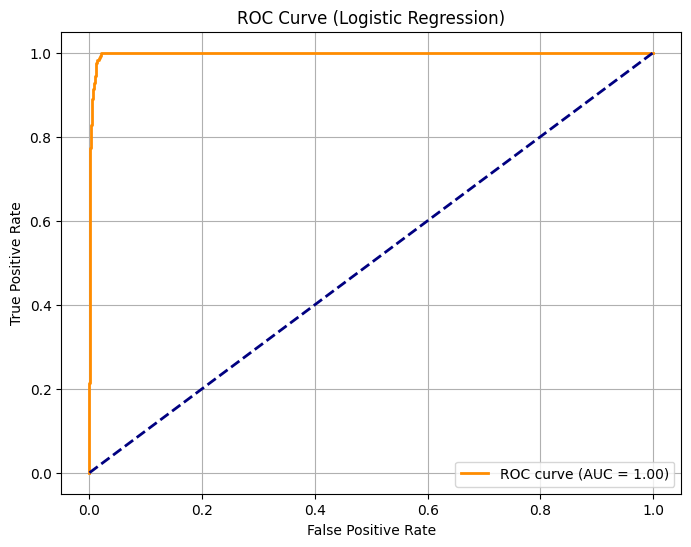

In [89]:
# Plot ROC curve for Logistic Regression
fpr, tpr, _ = roc_curve(y, y_pred_proba_logistic[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


